In [1]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")

pandas2ri.activate()

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('exec_optim_semidist.R')

# Loading the function we have defined in R.
exec_function_r = robjects.globalenv['eval_basin_param']
get_basin_q = robjects.globalenv['get_basin_q']

R[write to console]: Loading required package: readr

R[write to console]: Loading required package: hydroGOF

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Rows: 5 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): code, order, codedown, supha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
info_str = "semidist_5043"

result_files = [
    (f"./results/new_data/config_{info_str}_0_MSE.csv",0,"MSE"),
    (f"./results/new_data/config_{info_str}_1_MSE.csv",1,"MSE"),
    (f"./results/new_data/config_{info_str}_2_MSE.csv",2,"MSE"),
    (f"./results/new_data/config_{info_str}_3_MSE.csv",3,"MSE"),
    (f"./results/new_data/config_{info_str}_0_NSE.csv",0,"NSE"),
    (f"./results/new_data/config_{info_str}_1_NSE.csv",1,"NSE"),
    (f"./results/new_data/config_{info_str}_2_NSE.csv",2,"NSE"),
    (f"./results/new_data/config_{info_str}_3_NSE.csv",3,"NSE"),
    (f"./results/new_data/config_{info_str}_0_R2.csv",0,"R2"),
    (f"./results/new_data/config_{info_str}_1_R2.csv",1,"R2"),
    (f"./results/new_data/config_{info_str}_2_R2.csv",2,"R2"),
    (f"./results/new_data/config_{info_str}_3_R2.csv",3,"R2"),
    (f"./results/new_data/config_{info_str}_0_KGE.csv",0,"KGE"),
    (f"./results/new_data/config_{info_str}_1_KGE.csv",1,"KGE"),
    (f"./results/new_data/config_{info_str}_2_KGE.csv",2,"KGE"),
    (f"./results/new_data/config_{info_str}_3_KGE.csv",3,"KGE"),
]

# result_files_new = list(map(lambda x: x.replace(".", "_long."), result_files))

In [ ]:
agg_q = {}
result_q = {}

basin_df = pd.read_csv("data/CHGbasins.txt")
basin_df.sort_values(by=["order"])

eval_df = pd.DataFrame(columns=["model", "target", "basin_idx", "MSE", "RMSE", "Pbias", "NSE", "R2", "KGE"])

for file_name, model, target in result_files:
    print(file_name, "Yes" if os.path.exists(file_name) else "No")
    if os.path.exists(file_name):
        params = np.loadtxt(file_name, delimiter=",")

        prev_q = 0
        agg_q = {}
        basin_params = {}
        for idx in basin_df.index:
            basin_code = basin_df["code"][idx]
            codedown = basin_df["codedown"][idx]
            
            prev_q = 0
            if basin_code in agg_q:
                prev_q = agg_q[basin_code]
            
            if codedown not in agg_q:
                agg_q[codedown] = 0
            
            agg_q[codedown] += get_basin_q(model, params[idx], basin_code, prev_q)

            metrics = exec_function_r(model, params[idx], basin_code, prev_q)
            eval_df.loc[len(eval_df)] = [model, target, basin_code] + list(metrics)

    

./results/new_data/config_semidist_5043_0_MSE.csv Yes
./results/new_data/config_semidist_5043_1_MSE.csv Yes
./results/new_data/config_semidist_5043_2_MSE.csv Yes
./results/new_data/config_semidist_5043_3_MSE.csv Yes
./results/new_data/config_semidist_5043_0_NSE.csv Yes
./results/new_data/config_semidist_5043_1_NSE.csv Yes
./results/new_data/config_semidist_5043_2_NSE.csv Yes
./results/new_data/config_semidist_5043_3_NSE.csv Yes
./results/new_data/config_semidist_5043_0_R2.csv Yes
./results/new_data/config_semidist_5043_1_R2.csv Yes
./results/new_data/config_semidist_5043_2_R2.csv Yes
./results/new_data/config_semidist_5043_3_R2.csv Yes
./results/new_data/config_semidist_5043_0_KGE.csv Yes
./results/new_data/config_semidist_5043_1_KGE.csv Yes
./results/new_data/config_semidist_5043_2_KGE.csv Yes
./results/new_data/config_semidist_5043_3_KGE.csv Yes


In [ ]:
# eval_df["target"] = list(map(lambda x: x[:-6], eval_df["target"]))
eval_df["basin_idx"] = eval_df["basin_idx"].astype(str)

In [ ]:
# eval_df[eval_df["target"] == "NSE"]
eval_df.to_csv("semidist_5043_table.txt", index=False)

In [ ]:
eval_df[eval_df["basin_idx"] == "5043"]

,model,target,basin_idx,MSE,RMSE,Pbias,NSE,R2,KGE
4,0,MSE,5043,120.584948,10.981118,-3.1,0.328984,0.503665,0.682445
9,1,MSE,5043,121.390803,11.017749,-2.0,0.324499,0.487446,0.681211
14,2,MSE,5043,135.525156,11.641527,-6.0,0.245846,0.446690,0.646451
19,3,MSE,5043,115.206648,10.733436,-3.0,0.358912,0.497423,0.694531
24,0,NSE,5043,118.228621,10.873299,-2.8,0.342096,0.490206,0.687725
29,1,NSE,5043,122.552541,11.070345,-1.9,0.318035,0.485000,0.678543
34,2,NSE,5043,120.068197,10.957563,-2.0,0.331859,0.495465,0.684458
39,3,NSE,5043,118.683644,10.894202,-3.1,0.339564,0.506283,0.687175
44,0,R2,5043,300.368599,17.331145,39.1,-0.671455,0.579167,0.162064
49,1,R2,5043,609.047978,24.678897,74.1,-2.389156,0.574927,-0.301461


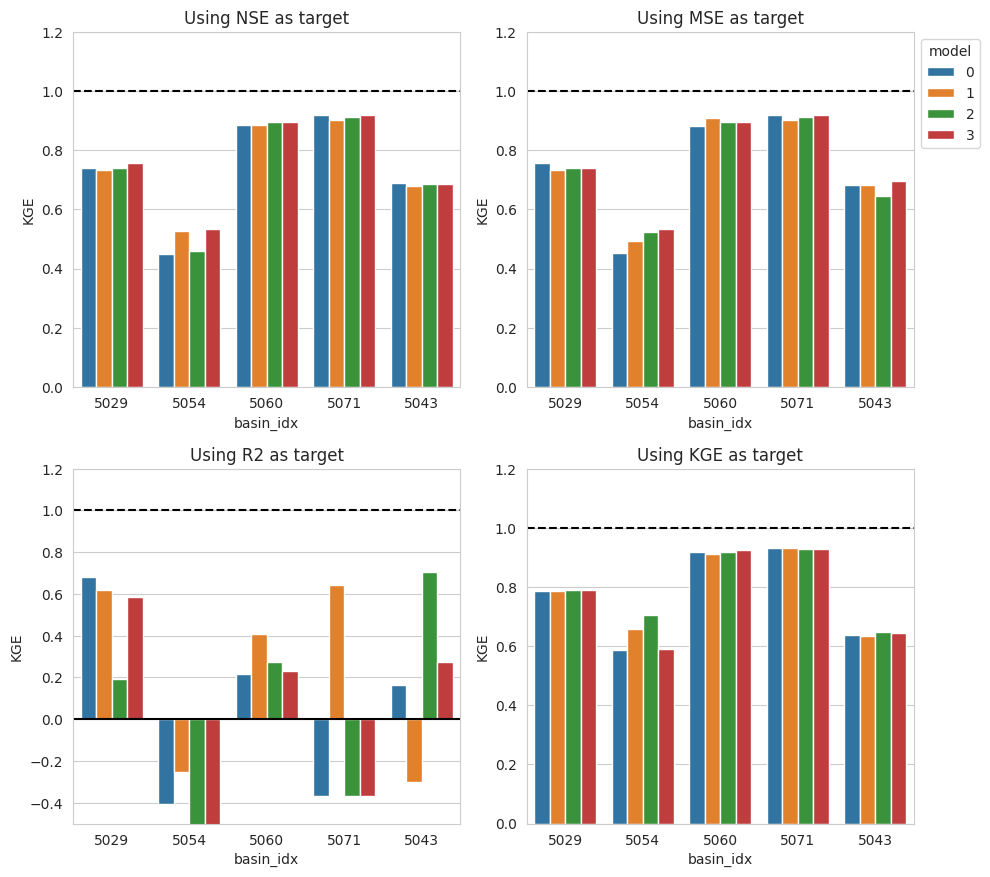

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(10, 10))


metric_measure = "KGE"
for idx, metric in enumerate(["NSE", "MSE", "Pbias", "KGE"]):    
    ax = axes[idx//2, idx%2]

    fig.tight_layout(h_pad=2)
    plt.subplots_adjust(top=0.85)

    data_to_plot = eval_df[eval_df["target"] == metric][['basin_idx', 'model', metric_measure]]
    hist_ax = sns.barplot(data=data_to_plot, x="basin_idx", y=metric_measure, hue="model", ax=ax)
    hist_ax.set(title = f"Using {metric} as target")


    if idx == 1:
        sns.move_legend(hist_ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        hist_ax.get_legend().remove()
    

    if metric_measure not in ["MSE", "RMSE", "Pbias"]:
        ax.axhline(1, color="k", linestyle="--")
        if metric == "R2" and metric_measure in ["NSE", "KGE"]:
            hist_ax.set(ylim = [-0.5, 1.2])
            ax.axhline(0, color="k")
        else:
            hist_ax.set(ylim = [0, 1.2])
    

    if metric_measure == "Pbias":
        hist_ax.set(ylim = [-27, 27], yticks = range(-25,30,5))
        ax.axhline(0, color="k")

plt.show()